In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from rcpsp_inst import RCPSPInstance, load_dataset
from net import Net
from aco import ACO_RCPSP
import random

# torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
ALPHA = 0.05
T=5
device = 'cpu'

In [2]:
def train_instance(model, optimizer, rcpsp: RCPSPInstance, n_ants):
    model.train()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=None,
        heuristic=heu_mat,
        device=device,
        train = True
    )
    
    costs, log_probs = aco.sample()
    assert log_probs is not None
    assert pyg_data.num_nodes is not None
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants 
    # k_sparse = pyg_data.num_edges // pyg_data.num_nodes
    # entropy_loss = ALPHA * (-torch.sum(Categorical(phe_mat).entropy()) / k_sparse)
    # print(reinforce_loss.item(), entropy_loss.item())
    loss = reinforce_loss / rcpsp.n
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0, norm_type=2)
    optimizer.step()
    return loss.item()

def infer_instance(model, rcpsp, n_ants):
    model.eval()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=None,
        heuristic=heu_mat,
        device=device,
        train = True
    )
    costs, log_probs = aco.sample()
    result = aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = result.cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost

In [3]:
def train_epoch(trainset,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    losses = []
    for _ in range(steps_per_epoch):
        data = trainset[random.randint(0,len(trainset)-1)]
        loss = train_instance(net, optimizer, data, n_ants)
        losses.append(loss)
    return losses

@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for instance in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, instance, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    trainset, testset = load_dataset(f"../data/rcpsp/j{n_node}rcp")
    testset = testset[:20]
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, testset, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    loss_list = []
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        losses = train_epoch(trainset, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, testset, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        loss_list.append(sum(losses))
        
    print('total training duration:', sum_time)
    # for epoch in range(epochs):
    #     print(f'[epoch {epoch}] loss:', loss_list[epoch], "val:", val_results[epoch])

    torch.save(net.state_dict(), f'../pretrained/rcpsp/rcpsp{n_node}-{net.emb_net.feats}.pt')

ZeroDivisionError: division by zero

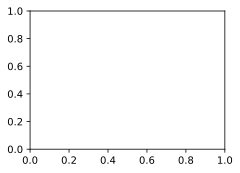

In [5]:
# j30
n_node, n_ants = 30, 20
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 207.69052577018738


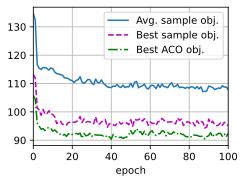

In [ ]:
# j60
n_node, n_ants = 60, 20
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 454.07165265083313


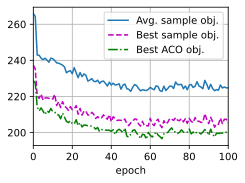

In [ ]:
# j120
n_node, n_ants = 120, 20
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)